In [275]:
#import
import warnings
warnings.filterwarnings("ignore", category=Warning)
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import re
import gc
# nltk.download('vader_lexicon')

# Task 1: The real impact of American political efforts on their actual emissions, and how it is correlated

## Task 1.1 How much did American politicians care about global warming

### We need to retrieve quotations related to climate. Firstly we perform a demo using the first 1,000,000 quotations in 2013, in order to create our list of keywords for retrieval.

In [2]:
# load data
def load_quotebank(path_to_file, chunksize=5*1e6, samplesize=5*1e6) -> pd.DataFrame:
    """Load the first 10000 quotations of each year from quotebank dataset
    """
    data_quotebank = pd.DataFrame()
    cnt = 0
    numbatch = samplesize // chunksize
    for chunk in pd.read_json(path_to_file, lines=True, chunksize=chunksize):
        data_quotebank = data_quotebank.append(chunk)
        cnt = cnt + 1
        if cnt == numbatch:
            break
    return data_quotebank

In [3]:
quotes_2013 = load_quotebank('./quotes-2013.json.bz2')

In [2]:
# clean data
def clean_quotebank(data_quotebank) -> pd.DataFrame:
    """Clean quotebank dataset
    """
    # Get the columns we need
    data_quotebank = data_quotebank[['quoteID', 'quotation', 'date', 'numOccurrences', 'speaker', 'qids']].copy()
    # Remove the time in date
    data_quotebank.loc[:, 'date'] = data_quotebank['date'].astype('str')
    data_quotebank.loc[:, 'date'] = data_quotebank['date'].apply(lambda x: re.compile(r'\d{4}-\d{2}-\d{2}').findall(x)[0])
    # Remove data with unknown speakers
    data_quotebank.loc[data_quotebank['speaker'] == 'None', 'speaker'] = None
    data_quotebank.loc[data_quotebank['speaker'].isna(), 'qids'] = None
    # Remove redundant qids
    def get_first_qid(qids):
        try:
            return qids[0]
        except:
            return None
    # data_quotebank.loc[:, 'qids'] = pd.Series([sample[0] for sample in data_quotebank.qids])
    data_quotebank.loc[:, 'qids'] = data_quotebank['qids'].apply(get_first_qid)
    # data_quotebank_cleaned = data_quotebank
    data_quotebank = data_quotebank.rename(columns={'qids': 'id'})
    return data_quotebank

In [5]:
quotes_2013 = clean_quotebank(quotes_2013)

Some insights on **how we decided the targeted keywords** for our topic: global warming

- We firstly use google to search "words related to global warming" and got words like "carbon dioxide", "methane", "greenhouse", "renewable energy", "UNFCCC", "IPCC", "average temperature", "biodiversity", "electric vehicle", "Paris Agreement" and "sea level"
- We also added the keywords we came up with, such as "global warming", "climate" and "environment"
- After the related quotations have been retrieved, we check on the original quotations and extract the words that usually occur with our targeted words at the same time, for example, "emission", "environmental","air pollutants". We also checked the precision of the results and found that some words can occur in other non-related context, for example, a quotation containing the word "environment" can be "I grew up in an environment in which everybody was doing something with their hands.", which has nothing to do with global warming. In this case, we changed the keyword "environment" into "environmental" to increase the precision.
- To get higher recall, we 1) search for "climate" instead of "climate change"; 2) use different expression for same word, such as carbon dioxide and CO2; 3) ignore capital letters

In [3]:
regex = "climate|emission|carbon dioxide|CO2|greenhouse|global warming|renewable energy|clean energy| \
         environmental|UNFCCC|IPCC|methane|average temperature|biodiversity|electric vehicle|air pollutants| \
         Paris Agreement|sea level"
def is_climate(x):
    keyword_list = re.findall(regex,x,re.IGNORECASE)
    if keyword_list:
        return keyword_list
    else:
        return False

In [ ]:
quotes_2013['is_climate'] = quotes_2013['quotation'].apply(is_climate)

In [7]:
quotes_2013_target = quotes_2013[~(quotes_2013['is_climate'] == False)]

In [8]:
quotes_2013_target.head()

,quoteID,quotation,date,numOccurrences,speaker,id,is_climate
292,2013-05-30-003101,"Alternatively, in the case of a cap and trade ...",2013-05-30,1,None,None,"[emission, emission]"
501,2013-01-22-004752,"as a first step, we use global general circula...",2013-01-22,7,bin wang,Q22103137,[climate]
663,2013-06-20-006940,"because of the Tea Party, Global Warming will ...",2013-06-20,2,Al Gore,Q19673,[Global Warming]
1055,2013-08-21-010630,Coral reefs have had a hard time adjusting eve...,2013-08-21,1,Ove Hoegh-Guldberg,Q7113303,[carbon dioxide]
1272,2013-12-05-015837,Everybody lists the negative part of global wa...,2013-12-05,1,Gov. Paul LePage,Q881196,[global warming]


In [9]:
len(quotes_2013_target)

14155

In [10]:
print("the proportion of quotations that are related to climate is %.3f%%" % (len(quotes_2013_target) / len(quotes_2013)*100))

the proportion of quotations that are related to climate is 0.283%


how many keywords are there in each quotation?

/home/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'number of quotations')

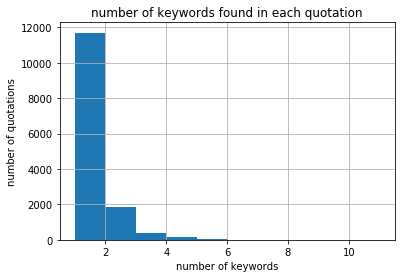

In [11]:
quotes_2013_target['keywords_num'] = quotes_2013_target['is_climate'].apply(lambda x: len(x))
quotes_2013_target['keywords_num'].hist()
plt.title('number of keywords found in each quotation')
plt.xlabel('number of keywords')
plt.ylabel('number of quotations')

most of the retrieved quotations contain only 1 keyword

how frequent does a keyword occur?

Text(0.5, 1.0, 'frequency of keywords')

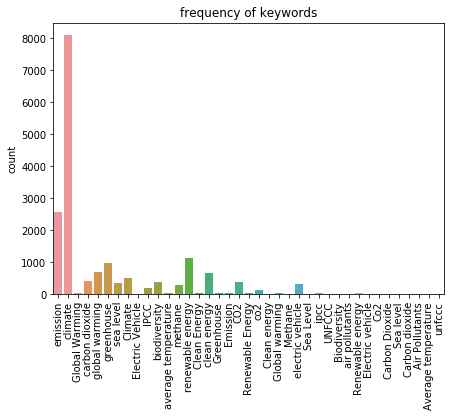

In [12]:
total_key_words = quotes_2013_target['is_climate'].sum()
plt.figure(figsize=(7,5))
sns.countplot(x=total_key_words)
plt.xticks(rotation=90)
plt.title("frequency of keywords")

the keyword "climate" occures most often,followed by "emission" and "renewable energy". We checked the retrieved quotations and most of them are topic-related, which implies satisfying precision. 

### We have decided the keywords list and now we can begin to work on the whole dataset

In [13]:
# clear memory
del quotes_2013, quotes_2013_target
gc.collect()

27

In [4]:
# import data loading function
from DataLoader import DataLoader
def load_data(path,chunksize=1e6):
    dl = DataLoader(path, chunksize=chunksize)
    df = dl.load()
    return df

In [5]:
# retrieval function
def quo_retrvl(dataframe):
    dataframe['is_climate'] = dataframe['quotation'].apply(is_climate)
    target = dataframe[~(dataframe['is_climate'] == False)]
    return target

In [6]:
# loop for all years
years = np.arange(2008,2021)
for year in years:
    quotes = load_data('quotes-'+str(year)+'.json.bz2')
    quotes = clean_quotebank(quotes)
    quotes_target = quo_retrvl(quotes)
    quotes_target.to_pickle('retrieved-'+str(year)+'.pkl')
    org_length = quotes.shape[0]
    tgt_length = quotes_target.shape[0]
    with open('len_record.txt','a',encoding='utf-8') as f:
        f.write('%d,%d,%d\n'%(year,org_length,tgt_length))
        f.close()
    print('%d is done!' % year)
    del quotes, quotes_target
    gc.collect()
    print('Memory has been cleared!')


Chunk 1 Finished! Time: 72.231s
Chunk 2 Finished! Time: 67.339s
Chunk 3 Finished! Time: 72.035s
Chunk 4 Finished! Time: 80.966s
Chunk 5 Finished! Time: 75.170s
Chunk 6 Finished! Time: 17.510s
2020 is done!
Memory has been cleared!


### Calculating *Political Attention Value*

Assuming that the propotion of climate-related topic occurrence in English news articles each year is related with the politicians' attention to it. We will calculate the **proportion** of occurrences of the quotations related to climate change issues every year from 2008 to 2020.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#Compute political attention value for each year
quo_len = pd.read_csv('Retrieved/len_record.txt', sep=',',header=None)
quo_len.columns = ['year','quo_all','quo_climate']
quo_len['poli_atten_val'] = quo_len['quo_climate'] / quo_len['quo_all']
quo_len

,year,quo_all,quo_climate,poli_atten_val
0,2008,4641330,17511,0.003773
1,2009,19567082,89447,0.004571
2,2010,17208434,59172,0.003439
3,2011,19632724,57811,0.002945
4,2012,19849872,50963,0.002567
5,2013,18614447,53052,0.002850
6,2014,19896843,62901,0.003161
7,2015,20874338,80053,0.003835
8,2016,13862129,44406,0.003203
9,2019,21763302,124051,0.005700


In [3]:
# results of 2017 and 2018 are stored seperately due to the large size of dataset
# now we combine them with other years
quo_len_2017 = pd.read_csv('Retrieved/len_record_2017.txt', sep=',',header=None)
quo_len_2017.columns = ['year','quo_all','quo_climate']
quo_all = quo_len_2017['quo_all'].sum()
quo_climate = quo_len_2017['quo_climate'].sum()
quo_len = quo_len.append({'year':2017,'quo_all':quo_all,'quo_climate':quo_climate,'poli_atten_val':quo_climate/quo_all}, ignore_index=True)

quo_len_2018 = pd.read_csv('Retrieved/len_record_2018.txt', sep=',',header=None)
quo_len_2018.columns = ['year','quo_all','quo_climate']
quo_all = quo_len_2018['quo_all'].sum()
quo_climate = quo_len_2018['quo_climate'].sum()
quo_len = quo_len.append({'year':2018,'quo_all':quo_all,'quo_climate':quo_climate,'poli_atten_val':quo_climate/quo_all}, ignore_index=True)

In [4]:
quo_len['year'] = quo_len['year'].astype("int")
quo_len['poli_atten_val'] = quo_len['poli_atten_val']*100
quo_len = quo_len.sort_values('year')

In [5]:
# save it to file
poli_atten_val = quo_len[['year','poli_atten_val']]
poli_atten_val.to_csv('poli_atten_val.csv')

In [6]:
quo_len

,year,quo_all,quo_climate,poli_atten_val
0,2008,4641330.0,17511.0,0.377284
1,2009,19567082.0,89447.0,0.457130
2,2010,17208434.0,59172.0,0.343855
3,2011,19632724.0,57811.0,0.294462
4,2012,19849872.0,50963.0,0.256742
5,2013,18614447.0,53052.0,0.285004
6,2014,19896843.0,62901.0,0.316136
7,2015,20874338.0,80053.0,0.383500
8,2016,13862129.0,44406.0,0.320340
11,2017,26611588.0,93541.0,0.351505


check out total number of quotations each year in the given dataset

Text(0, 0.5, 'Number of quotations')

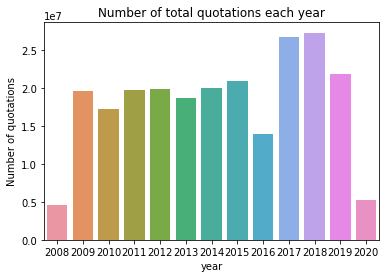

In [7]:
sns.barplot(x='year', y="quo_all", data=quo_len)
plt.title('Number of total quotations each year')
plt.ylabel('Number of quotations')

The average data size is around 20 million. In 2008 and 2020, the data size is much smaller, with around 5 million quotations.

check out number of retrieved climate-related quotations each year

Text(0, 0.5, 'Number of quotations')

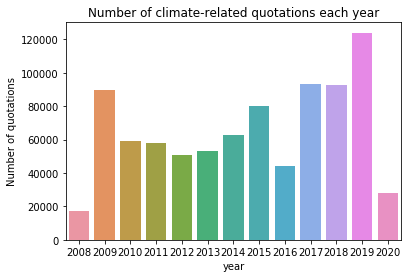

In [8]:
sns.barplot(x='year', y="quo_climate", data=quo_len)
plt.title('Number of climate-related quotations each year')
plt.ylabel('Number of quotations')

The number of climate-related quotations is much less, with an average of about 60,000. Unsurprisingly, the number is still small in 2008 and 2020.

Text(0, 0.5, 'political attention value (%)')

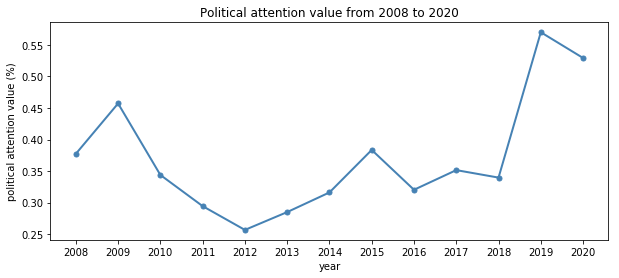

In [9]:
# plot the trend of political attention value
fig = plt.figure(figsize=(10,4))
plt.plot(quo_len.year,quo_len.poli_atten_val,linewidth=2,color ='steelblue',marker='o',markersize=5)
plt.title('Political attention value from 2008 to 2020')
plt.xlabel('year')
plt.xticks(np.arange(2008,2021))
plt.ylabel('political attention value (%)')

Strating with a relatively high attention for climate issue from american politics in 2008,the value firstly experienced a small rise in 2009 and then drop continually between 2009 and 2012. Apparently, year 2012 is a watershed in the past few years, whose value reached valley among all. Since then, the political attention value has climbed, and especially stayed high in recent years. Although this value may not has absolute strong relation to what we want, as chief political camps, mass media coverage does reflect intergrowth of political trending in climate change issue.

### Import data from EPA's annual Inventory of the U.S. Greenhouse Gas Emissions and Sinks

In [10]:
CO2_data = pd.read_csv('CO2_data.csv')
CO2_data = CO2_data.T
CO2_data.columns = ['CO2_emission']
CO2_data

,CO2_emission
2008,7224.648980
2009,6772.000071
2010,6991.106343
2011,6827.402421
2012,6585.907766
2013,6764.669110
2014,6824.956709
2015,6671.112065
2016,6520.337839
2017,6483.291331


Text(0, 0.5, 'CO2 Emissions (MMT CO2 eq.)')

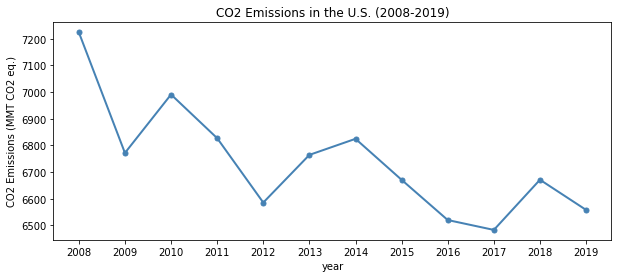

In [11]:
# plot the trend of annual CO2 emissions
fig = plt.figure(figsize=(10,4))
plt.plot(CO2_data.index,CO2_data.CO2_emission,linewidth=2,color ='steelblue',marker='o',markersize=5)
plt.title('CO2 Emissions in the U.S. (2008-2019)')
plt.xlabel('year')
plt.ylabel('CO2 Emissions (MMT CO2 eq.)')

Starting from 2008, there is in general a decreasing trend of annual CO2 emission, accompanied with some fluctuation. In 2009, the emision dropped greatly by 6.3% due to factory shutdowns caused by the financial crisis. In 2010, the CO2 emission from industry production rises again, then followed by a continued decline from 2010 to 2012. However, from 2012-2014, the annual CO2 emissions shows a worrying upward trend, increased by 3.6% from 6586 MMT in 2012 to 6825 MMT in 2014. After that, the CO2 emission begins to drop continually and reaches the lowest point of 6483 MMT per year, followed by a significant increase in 2018 and again a small drop in 2019.

## Task 1.2: How did the political attitudes towards mitigating global warming fluctuate between 2008-2020

### Now let's apply the sentiment analysis on the quotations retrieved to obtain *political support rate*

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
nltk.download('vader_lexicon')

# use vader package
class SentimentCalculator:
    def __init__(self) -> None:
        self._sid = SentimentIntensityAnalyzer()

    def sentiment_score(self, quote: str) -> float:
        full_score = self._sid.polarity_scores(quote)
        return full_score['compound']


def get_attitude(score):
    if score >= 0.05:
        return 'POSITIVE'
    elif score <= -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'


def get_sentiment(year, sc):
    quotes = pd.read_pickle(
        '/Users/mcx059/Data/Workspace/Python/ADAProject/Milestone3/Retrieved/retrieved-' + str(year) + '.pkl')
    quotes = quotes.dropna(subset=['speaker'])
    sents = quotes.quotation.apply(sc.sentiment_score)
    sents_label = sents.apply(get_attitude)
    quotes['Score'] = sents
    quotes['Sentiment'] = sents_label
    return quotes


sc = SentimentCalculator()
years = range(2008, 2021)
out = '/Users/mcx059/Data/Workspace/Python/ADAProject/Milestone3/Sentiment/'
for year in tqdm(years):
    df = get_sentiment(year, sc)
    df.to_pickle(out + 'sentiment_' + str(year) + '.pkl')
    with open(out + 'log.txt', 'a', encoding='utf-8') as f:
        f.write('Year %d, %d lines\n' % (year, df.shape[0]))


In [14]:
sentiment_2008 = pd.read_csv('Sentiment_csv/sentiment_2008.csv')
sentiment_2009 = pd.read_csv('Sentiment_csv/sentiment_2009.csv')
sentiment_2010 = pd.read_csv('Sentiment_csv/sentiment_2010.csv')
sentiment_2011 = pd.read_csv('Sentiment_csv/sentiment_2011.csv')
sentiment_2012 = pd.read_csv('Sentiment_csv/sentiment_2012.csv')
sentiment_2013 = pd.read_csv('Sentiment_csv/sentiment_2013.csv')
sentiment_2014 = pd.read_csv('Sentiment_csv/sentiment_2014.csv')
sentiment_2015 = pd.read_csv('Sentiment_csv/sentiment_2015.csv')
sentiment_2016 = pd.read_csv('Sentiment_csv/sentiment_2016.csv')
sentiment_2017 = pd.read_csv('Sentiment_csv/sentiment_2017.csv')
sentiment_2018 = pd.read_csv('Sentiment_csv/sentiment_2018.csv')
sentiment_2019 = pd.read_csv('Sentiment_csv/sentiment_2019.csv')
sentiment_2020 = pd.read_csv('Sentiment_csv/sentiment_2020.csv')

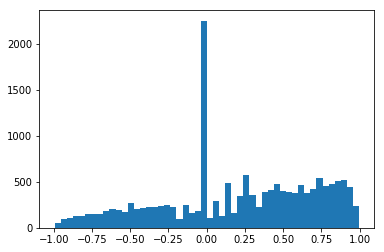

In [15]:
# see how the sentiment score id distributed (2008 as an example)
plt.hist(sentiment_2008['Score'].values,bins=50)
plt.show()

*Discuss*: A large number of quotations have score around 0, let's see if these quotations are "neutral" (-0.05~0.05) or "negative" (<-0.05>) according to our threshold.

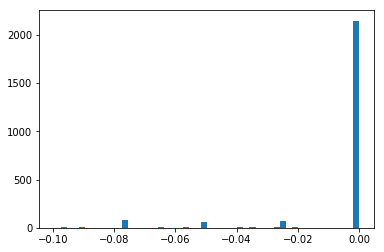

In [16]:
# in detail, see if these quotations are "neutral" (-0.05~0.05) or "negative" (<-0.05>)
plt.hist(sentiment_2008[(sentiment_2008['Score'] >= -0.1) & (sentiment_2008['Score'] <= 0)]['Score'].values,bins=50)
plt.show()

*Discuss*: They belong to "neutral" as their scores are no smaller than -0.02. Meanwhile, since a large number of quotations have score around (-0.02,0), the threshold for deciding "neutral" and "negative" plays an important role in this case. The (-0.05,0.05) standardized threshold is recommended by the developer of [Vader](https://github.com/cjhutto/vaderSentiment) toolkit, which is adopted in our study as well. However, it can be biased and result in different sentiment classification results.
Now let's see how the quotation scores of other years are distributed.

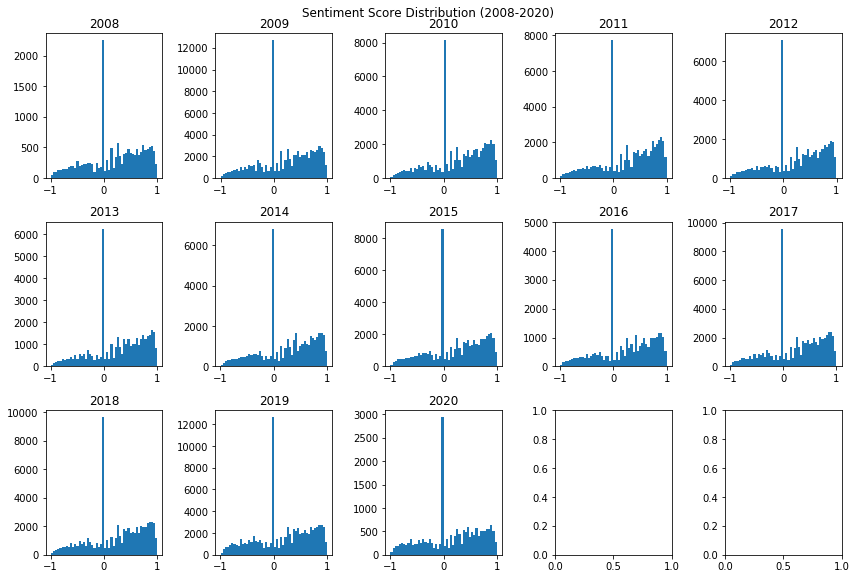

In [43]:
# see how the quotation scores of other years are distributed
sentiment_list = [sentiment_2008,sentiment_2009,sentiment_2010,sentiment_2011,sentiment_2012,sentiment_2013,sentiment_2014,\
                  sentiment_2015,sentiment_2016,sentiment_2017,sentiment_2018,sentiment_2019,sentiment_2020]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for idx, sentiment in enumerate(sentiment_list):
    ax = axes[int(idx/5), idx%5] # int(idx / 4) = math.floor(i/4)
    ax.hist(sentiment['Score'].values,bins=50)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(2008+idx)
plt.suptitle('Sentiment Score Distribution (2008-2020)',x=0.5,y=1)
fig.tight_layout()
plt.show()

*Discuss*: The number of quotations scored between -0.05 and 0 is extremely high in **all** years. It seems that this is not a coincidence. Now we check some of these quotations to see whether they are truly neutral.

In [19]:
for quot in sentiment_2020[(sentiment_2020['Score'] >= -0.05) & (sentiment_2020['Score'] <= 0)]['quotation'][6:11]:
    print(quot)

Climate change is real-but now is not the time,
When it opens, LNG Canada's liquefaction facility in Kitimat will become BC's largest point-source emitter of greenhouse gasses (GHGs),
the human contribution: changes in greenhouse gases and deforestation
Is this a coincidence, or could the Yarrabubba impact event be an unexpected cause of global climate change.
If you go to any of the right-wing think tanks or read the Murdoch press, it's just full of climate denialism and it's designed to deflect from the real objective which has to be to reduce our greenhouse gas emissions,


*Discuss*: The quotations above are labeled "neutral" and they seem like a description of fact, but in fact, the first quotation implies a contempt for climate change (which should be classified as "negative"), and the last one alludes to concerns about climate change (which should be classified as "positive"). Thus, under the topic of climate change, few of the quotations should be "neutral" and only describe some facts. Either they implies a concern/support that human should take actions to mitigate climate change, or they are not in favor of it, like the first quotation showed above. Therefore, in theory, the appropriate threshold of "neutral" is very hard to define, at least it should be a narrower range. Despite of this, we still adopt the recommended standard threshold for simplicity.

Now let's check out the sentiment label distribution (after classification with threshold).

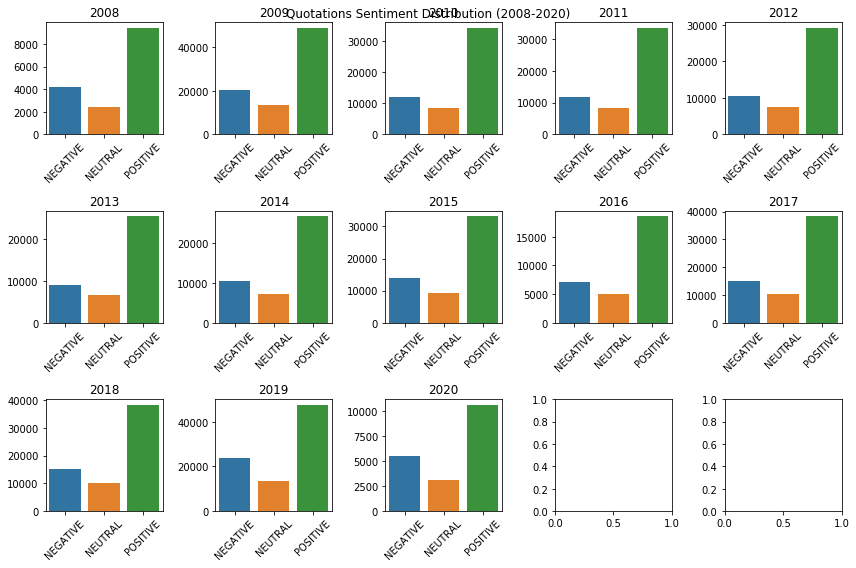

In [20]:
# check out the sentiment label distribution
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for idx, sentiment in enumerate(sentiment_list):
    ax = axes[int(idx/5), idx%5] # int(idx / 4) = math.floor(i/4)
    sns.countplot(x='Sentiment', data=sentiment,ax=ax,order=['NEGATIVE','NEUTRAL','POSITIVE'])
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(2008+idx)
plt.suptitle('Quotations Sentiment Distribution (2008-2020)')
fig.tight_layout()

*Discuss*: All the years follow a similar pattern, where positive quotations are dominant and neutral quotations are the least. This is consistent with common sense in a way that most of the politicians are in favour of taking actions to climate change. Now le's compute the proportion of the positive quotations each year as the political support rate of climate change.

In [21]:
# compute political support rate
poli_supp_rate = pd.DataFrame(columns = ['political_support_rate'],dtype=object)
for idx, sentiment in enumerate(sentiment_list):
    rate = np.array(sentiment['Sentiment'] == 'POSITIVE').sum() / sentiment.shape[0]
    poli_supp_rate = poli_supp_rate.append([{'political_support_rate':rate*100}], ignore_index=True)
poli_supp_rate.set_index(np.arange(2008,2021), inplace=True)

In [22]:
poli_supp_rate

,political_support_rate
2008,58.802664
2009,59.210319
2010,62.462764
2011,62.952094
2012,62.090865
2013,61.804009
2014,60.244683
2015,59.023064
2016,60.397613
2017,60.542705


Text(0, 0.5, 'Political Support Rate (%)')

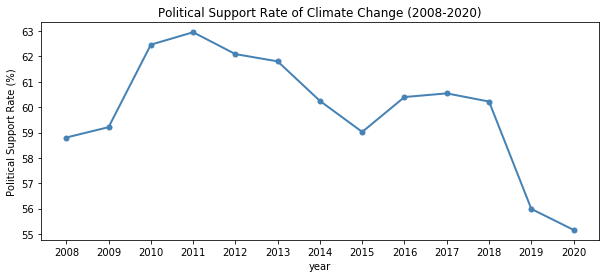

In [23]:
# plot the trend of political support rate
fig = plt.figure(figsize=(10,4))
plt.plot(poli_supp_rate.index,poli_supp_rate.political_support_rate,linewidth=2,color ='steelblue',marker='o',markersize=5)
plt.title('Political Support Rate of Climate Change (2008-2020)')
plt.xticks(np.arange(2008,2021))
plt.xlabel('year')
plt.ylabel('Political Support Rate (%)')

*Discuss*: In general, over 50% of quotations are positive in all years. Starting from 2008, the political support rate rises continually from 59% and reached the peak of 63% in 2011. After that, the rate decreases all the way again to 59%, followed by a slight rebound between 2015 and 2018. In recent years (2019-2020), it seems that the attitude of politicians turns to be more climate denial, with the political support rate falling to record lows of 55% in 2020.

## Task 1.3: What is the real impact of American political efforts on their actual emissions

### Now we perform a linear regression task between the actual annual CO2 emission in the U.S., political attention value, and political support rate.

In [25]:
# create a dataframe to aggregate the variables: annual CO2 emission, political attention value, and political support rate for each year
df = poli_atten_val.copy()
CO2_data.loc[2020,'CO2_emission'] = np.nan
df['political_support_rate'] = poli_supp_rate['political_support_rate'].values
df['CO2_emission'] = CO2_data['CO2_emission'].values
df = df.reset_index(drop=True)

In [26]:
# save to file
df.to_csv('data_task1.csv')

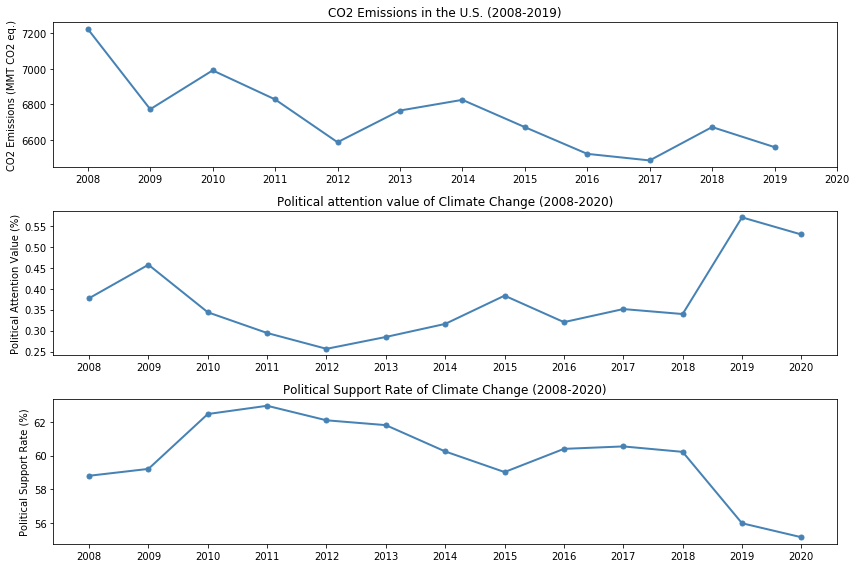

In [31]:
# plot the three variables
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
axes[0].plot(df.year,df.CO2_emission,linewidth=2,color ='steelblue',marker='o',markersize=5)
axes[0].set_title('CO2 Emissions in the U.S. (2008-2019)')
axes[0].set_xticks(np.arange(2008,2021))
axes[0].set_ylabel('CO2 Emissions (MMT CO2 eq.)')

axes[1].plot(df.year,df.poli_atten_val,linewidth=2,color ='steelblue',marker='o',markersize=5)
axes[1].set_title('Political attention value of Climate Change (2008-2020)')
axes[1].set_xticks(np.arange(2008,2021))
axes[1].set_ylabel('Political Attention Value (%)')

axes[2].plot(df.year,df.political_support_rate,linewidth=2,color ='steelblue',marker='o',markersize=5)
axes[2].set_title('Political Support Rate of Climate Change (2008-2020)')
axes[2].set_xticks(np.arange(2008,2021))
axes[2].set_ylabel('Political Support Rate (%)')
fig.tight_layout()

Now we perform regression analysis

In [28]:
import statsmodels.formula.api as smf

# multiple regression
mod = smf.ols(formula='CO2_emission ~ poli_atten_val + political_support_rate', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           CO2_emission   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.198
Method:                 Least Squares   F-statistic:                   0.09190
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.913
Time:                        20:06:19   Log-Likelihood:                -80.667
No. Observations:                  12   AIC:                             167.3
Df Residuals:                       9   BIC:                             168.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4999

/home/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [29]:
# interaction
mod = smf.ols(formula='CO2_emission ~ poli_atten_val * political_support_rate', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           CO2_emission   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                 -0.216
Method:                 Least Squares   F-statistic:                    0.3480
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.792
Time:                        20:06:20   Log-Likelihood:                -80.053
No. Observations:                  12   AIC:                             168.1
Df Residuals:                       8   BIC:                             170.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/home/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


*Discuss*: Since we only have 12 samples data points, it is not enough to perform a solid regression analysis. The R-squares of the two regression models are not satisfactory, and since the p-values are far larger than 0.05, neither of the two predictors are significant. Therefore, we cannot come to any meaningful conclusions according to the regression analysis. However,we had another interesting finding that the attention value seems correlated. Now let's look into some details.

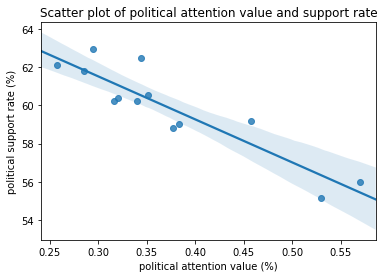

In [36]:
# Scatter plot of political attention value and support rate
sns.regplot(x='poli_atten_val', y='political_support_rate', data=df)    
plt.title("Scatter plot of political attention value and support rate")
plt.xlabel('political attention value (%)')
plt.ylabel('political support rate (%)')
plt.show()

In [32]:
# calculate the correlation and p-value
from scipy.stats import pearsonr, spearmanr

r, p = pearsonr(df['poli_atten_val'], df['political_support_rate'])
print('Pearson correlation: %.2f, p-value: %.6f' % (r,p))

r, p = spearmanr(df['poli_atten_val'], df['political_support_rate'])
print('Spearman correlation: %.2f, p-value: %.6f' % (r,p))

Pearson correlation: -0.91, p-value: 0.000019
Spearman correlation: -0.81, p-value: 0.000839


*Discuss*: There is a significant **negative** correlation betweeen political attention value and support rate. The underlying explanation can be that, when politicians focus more on the climate topic (increase in political attention), the more more objections there will be. This is because:
1. Normally when a ruling party is spending a lot of money in environmental protection but without much progress, it becomes a weakness that is caught out on and criticized.
2. Politicians tend to have the consensus that actions should be taken to mitigate climate change, but when a lot of politicians are constantly arguing about it, the opposite opinions will more likely to emerge.

# Task 2: How do politicians’ demographic factors (party affiliation, nationality, gender, ethnic group, occupation, religion, age,  academic degree) affect their attitudes to this issue

### Firstly we need to clean the data of the speakers from Wikipedia, their demographic factors include: 
- party
- nationality
- gender
- ethnic group
- occupation
- religion
- birth year
- highest academic degree

Besides theses factors, the dataframe should also contain their 'id' (which can be linked to the 'id' column of our quotation dataframe) and 'label' (their names).

There are two files concerning Wiki data, one is *speaker_attributes.parquet*, containing all the attributes of the speakers in the form of a list [Qxxx] (a.k.a. 'qid'), another is *wikidata_labels_descriptions_quotebank*, which contains all the real descreptions of the attributes.

In [36]:
# load and clean wiki data
import pandas as pd

def load_wiki(path_to_file) -> pd.DataFrame:
    """Load wikidata of speakers
    """
    data_wiki = pd.read_parquet(path_to_file)
    data_wiki = data_wiki[['id', 'label', 'party', 'aliases', 'date_of_birth', 'nationality', 'gender', 'ethnic_group', 'occupation', 'academic_degree', 'candidacy', 'religion']]
    return data_wiki

def clean_wiki(data_wiki) -> pd.DataFrame:
    """Clean wikidata of speakers
    """
    # Remove rows with no ids
    data_wiki_cleaned = data_wiki.dropna(axis=0, subset=['id']).reset_index(drop=True)
    return data_wiki_cleaned

In [35]:
# load file into memory
wiki = load_wiki('Wiki/speaker_attributes.parquet')

In [37]:
# check out how speaker_attributes looks like
wiki = clean_wiki(wiki)
wiki.head(5)

,id,label,party,aliases,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,candidacy,religion
0,Q23,George Washington,[Q327591],"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],None,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",None,"[Q698073, Q697949]",[Q682443]
1,Q42,Douglas Adams,None,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],[Q7994501],"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,None
2,Q1868,Paul Otlet,None,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,None
3,Q207,George W. Bush,[Q29468],"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",None,"[Q327959, Q464075, Q3586276, Q4450587]","[Q329646, Q682443, Q33203]"
4,Q297,Diego Velázquez,None,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],None,[Q1028181],None,None,None


In [38]:
# drop some columns that we don't need
speaker_attributes = wiki.drop(labels='aliases', axis=1)

we keep the last QID of the nationality column, and the first QID of other attributes

In [39]:
def get_first_qid(qids):
    try:
        return qids[0]
    except:
        return None
    
def get_last_qid(qids):
    try:
        return qids[-1]
    except:
        return None

In [40]:
speaker_attributes.loc[:, 'party'] = speaker_attributes.party.apply(get_first_qid)
speaker_attributes.loc[:, 'nationality'] = speaker_attributes.nationality.apply(get_last_qid)
speaker_attributes.loc[:, 'gender'] = speaker_attributes.gender.apply(get_first_qid)
speaker_attributes.loc[:, 'ethnic_group'] = speaker_attributes.ethnic_group.apply(get_first_qid)
speaker_attributes.loc[:, 'occupation'] = speaker_attributes.occupation.apply(get_first_qid)
speaker_attributes.loc[:, 'religion'] = speaker_attributes.religion.apply(get_first_qid)

now we work on 'date_of_birth' and convert it to 'birth_year'

In [41]:
def get_birth_year(x):
    try:
        year = re.compile(r'\d{4}').findall(x[0])[0]
    except:
        year = None
    return year

def get_last_qid(qids):
    try:
        return qids[-1]
    except:
        return None

In [42]:
speaker_attributes['birth_year'] = speaker_attributes.date_of_birth.apply(get_birth_year)
speaker_attributes = speaker_attributes.drop(labels='date_of_birth', axis=1)

work on 'academic_degree' column

In [43]:
with_degree = speaker_attributes.loc[~speaker_attributes.academic_degree.isna()][['id', 'label', 'academic_degree']]
with_degree.head()

,id,label,academic_degree
16,Q997,Andrei Sakharov,[Q17281097]
17,Q1056,Italo Balbo,[Q1054679]
52,Q2567,Richard von Weizsäcker,[Q849697]
54,Q2677,Wilhelm II,[Q18745564]
79,Q4496,Mitt Romney,"[Q1765120, Q191701, Q1540185]"


In [44]:
# find the highest degree
def find_highest_degree(aca_list):
    degree = None
    if aca_list is not None:
        try:
            aca_list_label = str(list(map(search_label, aca_list)))
            if len(re.compile(r'[Dd]octor').findall(aca_list_label)) > 0:
                degree = 'Doctor'
            elif len(re.compile(r'[Mm]aster').findall(aca_list_label)) > 0:
                degree = 'Master'
            elif len(re.compile(r'[Bb]achelor').findall(aca_list_label)) > 0:
                degree = 'Bachelor'
        except:
            degree = None
    return degree

In [45]:
with_degree['highest_degree'] = with_degree.academic_degree.apply(find_highest_degree)
with_degree = with_degree.drop(labels='academic_degree', axis=1)

In [46]:
# merge with_degree with speaker_attributes
speaker_attributes = speaker_attributes.merge(with_degree[['id', 'highest_degree']], how='left', on='id')
speaker_attributes = speaker_attributes.drop(labels='academic_degree', axis=1)

In [47]:
speaker_attributes.loc[speaker_attributes.highest_degree.isna(), 'highest_degree'] = None
speaker_attributes.head()

,id,label,party,nationality,gender,ethnic_group,occupation,candidacy,religion,birth_year,highest_degree
0,Q23,George Washington,Q327591,Q30,Q6581097,None,Q82955,"[Q698073, Q697949]",Q682443,1732,None
1,Q42,Douglas Adams,None,Q145,Q6581097,Q7994501,Q214917,None,None,1952,None
2,Q1868,Paul Otlet,None,Q31,Q6581097,None,Q36180,None,None,1868,None
3,Q207,George W. Bush,Q29468,Q30,Q6581097,None,Q82955,"[Q327959, Q464075, Q3586276, Q4450587]",Q329646,1946,None
4,Q297,Diego Velázquez,None,Q29,Q6581097,None,Q1028181,None,None,1599,None


now check on the 'candidacy' column, in order to check the content rather than QID, we also load the *wikidata_labels_descriptions_quotebank* file and link it to *speaker_attributes*

In [48]:
wiki_label = pd.read_csv('Wiki/wikidata_labels_descriptions_quotebank.csv.bz2')

In [49]:
def search_label(qid: str, labels: pd.DataFrame = wiki_label) -> str:
    """Search for the label of a given qid
    """
    try:
        label = labels[labels['QID'] == qid]['Label'].values[0]
    except:
        label = None
    return label

In [50]:
list(map(search_label, speaker_attributes.candidacy.loc[9055460]))

['2018 Wigan Metropolitan Borough Council election in Wigan Central']

'candidacy' contains position/status infomation of the speaker in election, which is trivial and unimportant in our study. Thus, we drop this attribute.

In [51]:
speaker_attributes = speaker_attributes.drop(labels='candidacy', axis=1)

In [52]:
speaker_attributes.head()

,id,label,party,nationality,gender,ethnic_group,occupation,religion,birth_year,highest_degree
0,Q23,George Washington,Q327591,Q30,Q6581097,None,Q82955,Q682443,1732,None
1,Q42,Douglas Adams,None,Q145,Q6581097,Q7994501,Q214917,None,1952,None
2,Q1868,Paul Otlet,None,Q31,Q6581097,None,Q36180,None,1868,None
3,Q207,George W. Bush,Q29468,Q30,Q6581097,None,Q82955,Q329646,1946,None
4,Q297,Diego Velázquez,None,Q29,Q6581097,None,Q1028181,None,1599,None


### Finally, our *speaker_attributes* is ready to go, let's apply the *search_label* function to link the content to the QID in *speaker_attributes*  to check if it's working alright.

In [53]:
speaker_attributes.loc[:10,'occupation'].apply(search_label)

0           politician
1           playwright
2               writer
3           politician
4              painter
5     military officer
6                 poet
7           astronomer
8               singer
9         photographer
10          playwright
Name: occupation, dtype: object

-----

### Incident:

while we work on the dataset, we found out that, in fuction *clean_quotebank* at the very beginning, we made a mistake of only keeping the first qid of the speaker, since there's a possibility of duplicate names. Thus, we use the speakers' name to search for all their qid in the given xxx file, and build up a filter based on thier born year, which is performed following the method below:
1. for each quotation, extract the year of the quotation
2. suppose that the speaker's age is between 20 and 90 when the quotation has been made
3. substract 20/90 to get the possible born year range of the speaker
4. select the qid among all the qid candidates whose born year is within the range, if there are multiple, then select the first one with a its *party* not *None*

P.S. Cases of duplicate names are not dominant, which will not significantly affect our results

below is our remedy of the issue, this part of code was originally run on other computer and took a relatively long time. Therefore, we just peresent the code but won't run it here again, instead, we directly load in the processed data

In [57]:
# load in and merge all valid quotes
import os
quo_data = []
import pickle5 as pickle
for i,v in enumerate(os.listdir('Sentiment')):
    if not v.endswith('txt'):
        with open(os.path.join('Sentiment',v),'rb') as f:
            tmp_data = pickle.load(f)
#         tmp_data = pd.read_pickle(os.path.join('Sentiment',v))
        quo_data.append(tmp_data)
quo_data = pd.concat(quo_data,axis=0)

In [58]:
quo_data.shape

(658629, 9)

In [59]:
def search_label(qid: str, labels: pd.DataFrame = wiki_label) -> str:
    """Search for the label of a given qid
    """
    try:
        label = labels[labels['QID'] == qid]['Label'].values[0]
    except:
        label = None
    return label

In [60]:
def search_qids(label: str, labels: pd.DataFrame = wiki_label) -> str:
    """Search for the qid of a given label
    """
    try:
        label = labels[labels['Label'] == label]['QID'].values
    except:
        label = None
    return label

In [ ]:
wiki_label = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2')

In [ ]:
wiki_label_ = pd.read_pickle('speaker_attributes.pkl')

In [ ]:
data = pd.merge(quo_data, wiki_label_, on='id', how='inner')

In [ ]:
data_birth = data[~data.birth_year.isna()]
data_birth.birth_year = data_birth.birth_year.astype('int')

In [ ]:
anomaly = data_birth[data_birth.birth_year < 1900][['id', 'speaker', 'quotation', 'birth_year', 'date']]
anomaly.drop_duplicates(subset=['speaker'])
anomaly.speaker = anomaly.speaker.apply(lambda x: x.title())

In [ ]:
def find_proper_qid(speaker, date, id):
    speakers = wiki_label_[wiki_label_.label == speaker]
    speakers = speakers[~speakers.birth_year.isna()]
    quote_year = int(re.compile(r'\d{4}').findall(date)[0])
    if speakers.shape[0] >= 2:
        try:
            speaker_ = speakers[(speakers.birth_year.astype('int') >= (quote_year - 90)) & (speakers.birth_year.astype('int') <= (quote_year - 20))]
            if speaker_.shape[0] >= 1:
                speaker_p = speaker_[~speaker_.party.isna()]
                if speaker_p.shape[0] == 0:
                    qid = speaker_.id.values[0]
                else:
                    qid = speaker_p.id.values[0]
            qid = speaker_.id.values[0]
        except:
            speaker_ = speaker
            qid = id
        return qid
    else:
        return id

In [ ]:
speakers = anomaly.drop_duplicates(subset=['speaker'])

In [ ]:
better_qid = pd.DataFrame(columns=['speaker', 'id'])
for i in tqdm(range(len(speakers))):
    qid = find_proper_qid(speakers.speaker.iloc[i], speakers.date.iloc[i], speakers.id.iloc[i])
    tmp = {'speaker': speakers.speaker.iloc[i], 'id': qid}
    better_qid = better_qid.append([tmp], ignore_index=True)

In [ ]:
quo_data.speaker = quo_data.speaker.apply(lambda x: x.title())

In [ ]:
better_ = quo_data[quo_data.speaker.isin(better_qid.speaker)][['speaker', 'id']].sort_values('speaker').merge(better_qid, on='speaker')

In [ ]:
better_.drop_duplicates(subset=['speaker'])

In [ ]:
better_dict = dict(zip(better_.id_x, better_.id_y))

In [ ]:
quo_data['id'] = quo_data['id'].replace(better_dict)

In [63]:
# here we directly load the processed data  
quo_data = pd.read_csv('quo_data.csv')

In [64]:
quo_data.head()

,Unnamed: 0,quoteID,quotation,date,numOccurrences,speaker,id,is_climate,Score,Sentiment
0,86,2020-01-24-004182,"Also, spoke about a range of emerging sectors ...",2020-01-24,2,Piyush Goyal,Q7199798,['renewable energy'],0.5574,POSITIVE
1,419,2020-02-24-013709,For every doubling of carbon dioxide concentra...,2020-02-24,1,E. Calvin Beisner,Q19877395,['carbon dioxide'],0.9042,POSITIVE
2,1223,2020-01-29-062975,Many make the link today between their experie...,2020-01-29,5,Peter Maurer,Q117796,['climate'],-0.7579,NEGATIVE
3,1456,2020-03-05-054864,Riding responsibly is one of the core ethos of...,2020-03-05,1,Ashish Singh,Q21622888,['emission'],0.8442,POSITIVE
4,1513,2020-01-17-068930,Single crusades in Australia will have absolut...,2020-01-17,7,Barnaby Joyce,Q4861362,['climate'],0.0000,NEUTRAL


### Now we have the reasonable qid of each speaker!

-------------

### Merge the quotes data and speaker attributes to form a complete dataframe

In [65]:
speaker_attributes = pd.read_csv(r'./Wiki/speaker_attributes.csv')

In [66]:
speaker_attributes.drop(['Unnamed: 0'],axis=1,inplace=True)

In [303]:
data = pd.merge(quo_data,speaker_attributes,on='id',how='inner')
data.drop(['label'], axis=1, inplace=True)

In [304]:
quo_data.shape

(658629, 10)

In [305]:
data.shape

(654129, 18)

4500 quotations are filtered, now there are 654129 valid quotations for the analysis

now we replace the qids in the dataframe with its real textual content

In [306]:
def replace_qid(col_name: str):
    qid = data[col_name].value_counts().index.to_series()
    label = qid.apply(search_label)
    dic = pd.concat([qid,label],ignore_index=True,axis=1).set_index(0).T.to_dict('list')
    data[col_name].replace(dic,inplace=True)

In [307]:
char_list = ['party','nationality','gender','ethnic_group','occupation','religion']
for col in char_list:
    replace_qid(col)

we calculate the *age* of the speaker by substracting *birth_year* from *date*

In [308]:
data['date'] = data['date'].apply(lambda x: int(re.compile(r'\d{4}').findall(x)[0]))
data['age'] = data['date'] - data['birth_year']

In [309]:
data.head()

,Unnamed: 0,quoteID,quotation,date,numOccurrences,speaker,id,is_climate,Score,Sentiment,party,nationality,gender,ethnic_group,occupation,religion,birth_year,highest_degree,age
0,86,2020-01-24-004182,"Also, spoke about a range of emerging sectors ...",2020,2,Piyush Goyal,Q7199798,['renewable energy'],0.5574,POSITIVE,Bharatiya Janata Party,India,male,NaN,politician,Hinduism,1964.0,NaN,56.0
1,660572,2020-01-21-092711,We are like a pivot for the Indian Ocean and w...,2020,1,Piyush Goyal,Q7199798,"['climate', 'climate']",0.9020,POSITIVE,Bharatiya Janata Party,India,male,NaN,politician,Hinduism,1964.0,NaN,56.0
2,1308318,2020-01-19-047177,"U.S. President Donald Trump, German Chancellor...",2020,1,Piyush Goyal,Q7199798,['climate'],-0.2411,NEGATIVE,Bharatiya Janata Party,India,male,NaN,politician,Hinduism,1964.0,NaN,56.0
3,1884585,2020-01-28-105760,"We will have no emission from the railways, it...",2020,1,Piyush Goyal,Q7199798,"['emission', 'clean energy']",0.6486,POSITIVE,Bharatiya Janata Party,India,male,NaN,politician,Hinduism,1964.0,NaN,56.0
4,1938413,2020-01-21-092710,We are like a pivot for the Indian Ocean and w...,2020,2,Piyush Goyal,Q7199798,['climate'],0.5859,POSITIVE,Bharatiya Janata Party,India,male,NaN,politician,Hinduism,1964.0,NaN,56.0


### Now the *data* contains all the useful information and is ready to go! 

### In the following analysis, we try to answer our question: How do politicians’ demographic factors affect their attitudes to climate change?

### Firstly we get an overview of the distribution of the politicians’ demographic factors

check the missing value of each column

In [74]:
for char in ['party','nationality','gender','ethnic_group','occupation','religion','birth_year','highest_degree']:
    missing = data[char].isna().sum()
    print('%d out of %d quotations (%.1f%%) are missing in ' % (missing, len(data), missing/len(data)*100)+char+' column')

416356 out of 654129 quotations (63.7%) are missing in party column
118540 out of 654129 quotations (18.1%) are missing in nationality column
13507 out of 654129 quotations (2.1%) are missing in gender column
596883 out of 654129 quotations (91.2%) are missing in ethnic_group column
23872 out of 654129 quotations (3.6%) are missing in occupation column
525387 out of 654129 quotations (80.3%) are missing in religion column
95535 out of 654129 quotations (14.6%) are missing in birth_year column
598038 out of 654129 quotations (91.4%) are missing in highest_degree column


As there are too many missing values in *party*, *ethnic_group*, *religion*, *highest_degree* column, which might weaken the interpretability and result in fallacy

In [75]:
def get_discription(col: str):
    print('---------------',col,'---------------')
    count = data[col].value_counts()
    length = len(count)
    merge = pd.concat([count,count/count.sum()*100],axis=1)
    merge.columns = ['count','percent']
    print('There are %d different ' % (length) +col)
    print('Top Ones')
    print(merge[:5])

In [76]:
for char in ['party','nationality','gender','ethnic_group','occupation','religion','highest_degree']:
    get_discription(char)

--------------- party ---------------
There are 1314 different party
Top Ones
                            count    percent
Democratic Party            83750  35.222670
Republican Party            40139  16.881227
Australian Labor Party       7304   3.071837
Labour Party                 6484   2.726971
Liberal Party of Australia   5658   2.379581
--------------- nationality ---------------
There are 312 different nationality
Top Ones
                           count    percent
United States of America  248733  46.441021
United Kingdom             79039  14.757398
Australia                  34755   6.489118
Canada                     32801   6.124286
India                      15331   2.862456
--------------- gender ---------------
There are 12 different gender
Top Ones
                     count    percent
male                531054  82.896622
female              109208  17.047182
transgender female     176   0.027473
non-binary             112   0.017483
genderfluid             32   0.

We can see that there are about 1400 different parties. Most of the quotations come from Democratic Party (35%) and Republican Party (17%) in the U.S.
Similarly, male american politicians dominate our dataset

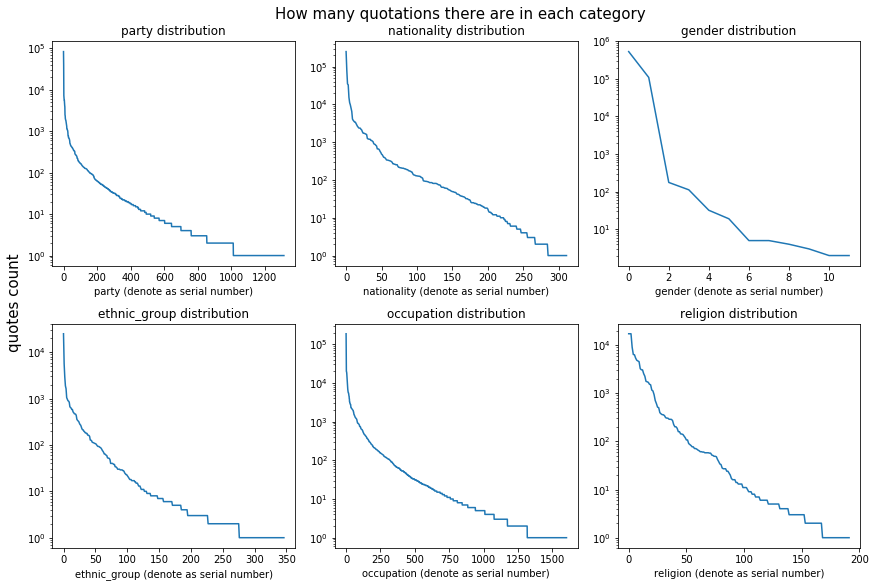

In [77]:
# plot distribution
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for idx, char in enumerate(['party','nationality','gender','ethnic_group','occupation','religion']):
    ax = axes[int(idx/3), idx%3]
    ax.semilogy(data[char].value_counts().values)
    ax.set_title(char+' distribution')
    ax.set_xlabel(char+' (denote as serial number)')
fig.text(-0.01, 0.5, 'quotes count', va='center', rotation='vertical',fontsize=15)
fig.text(0.3, 1, 'How many quotations there are in each category', va='center',fontsize=15)
fig.tight_layout()

These attributes all follow a power law distrubution, most of the speaker of quotations belong to a few major categories.

Text(0, 0.5, 'number of quotes belonging to birth year of speaker (in log)')

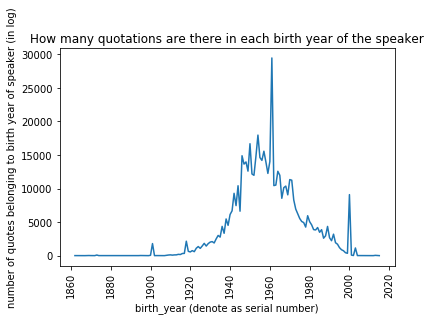

In [78]:
# plot for birth year
birth_year = data['birth_year'].value_counts()
birth_year = birth_year.sort_index(ascending=False)
plt.plot(birth_year.index[:150], birth_year.values[:150])
plt.xticks(rotation=90)
plt.title('How many quotations are there in each birth year of the speaker')
plt.xlabel('birth_year (denote as serial number)')
plt.ylabel('number of quotes belonging to birth year of speaker (in log)')

Text(0, 0.5, 'number of quotes')

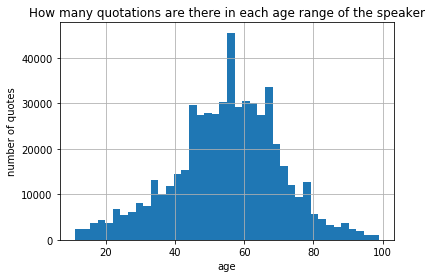

In [79]:
# plot for age
data[(data['age'] < 100) & (data['age'] > 10)]['age'].hist(bins=40)
plt.title('How many quotations are there in each age range of the speaker')
plt.xlabel('age')
plt.ylabel('number of quotes')

Most speakers are between the age 35~65

Text(0, 0.5, 'number of quotes')

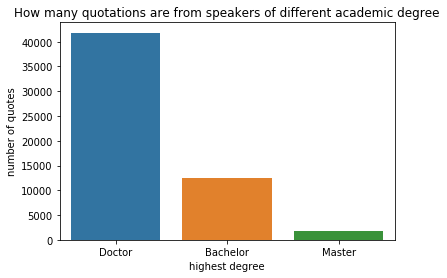

In [80]:
# plot for highest_degree
sns.countplot(x='highest_degree', data=data) 
plt.title('How many quotations are from speakers of different academic degree')
plt.xlabel('highest degree')
plt.ylabel('number of quotes')

Most of the speakers (with no missing value of 'degree') hold a doctoral degree

### Then we perform a naive analysis, calculating and comparing the negative rate of each category of speaker in each attribute (party, nationality, gender, ethnic group, occupation, religion, highest degree)

From the analysis above, we know the major categories of each attribute (e.g. Democratic Party and Republican Party are two major categories in *party*). Thus, we only focus on these major categories and compare the negative rate of each category. We draw barplots to visulize it.

In [81]:
target_dict = {'party':['Democratic Party','Republican Party'], 'nationality':['United States of America','United Kingdom','Australia','Canada'],\
               'gender':['male','female'],'ethnic_group':['African Americans','Jewish people'], \
               'occupation':['politician','researcher','journalist'],'religion':['Catholic Church','Catholicism','Protestantism','Judaism','Baptists','Presbyterianism'], \
                'highest_degree':['Doctor','Master','Bachelor']}

In [28]:
# a function to add percentage for hues to bar plots
def add_percent(Number_of_categories,ax):
    '''
    Add percentage for hues to bar plots
    '''
    # The bars are created in hue order, organize them
    bars = ax.patches
    # For each X variable
    for ind in range(Number_of_categories):
        # Get every hue bar
        hueBars=bars[ind:][::Number_of_categories]
        # Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

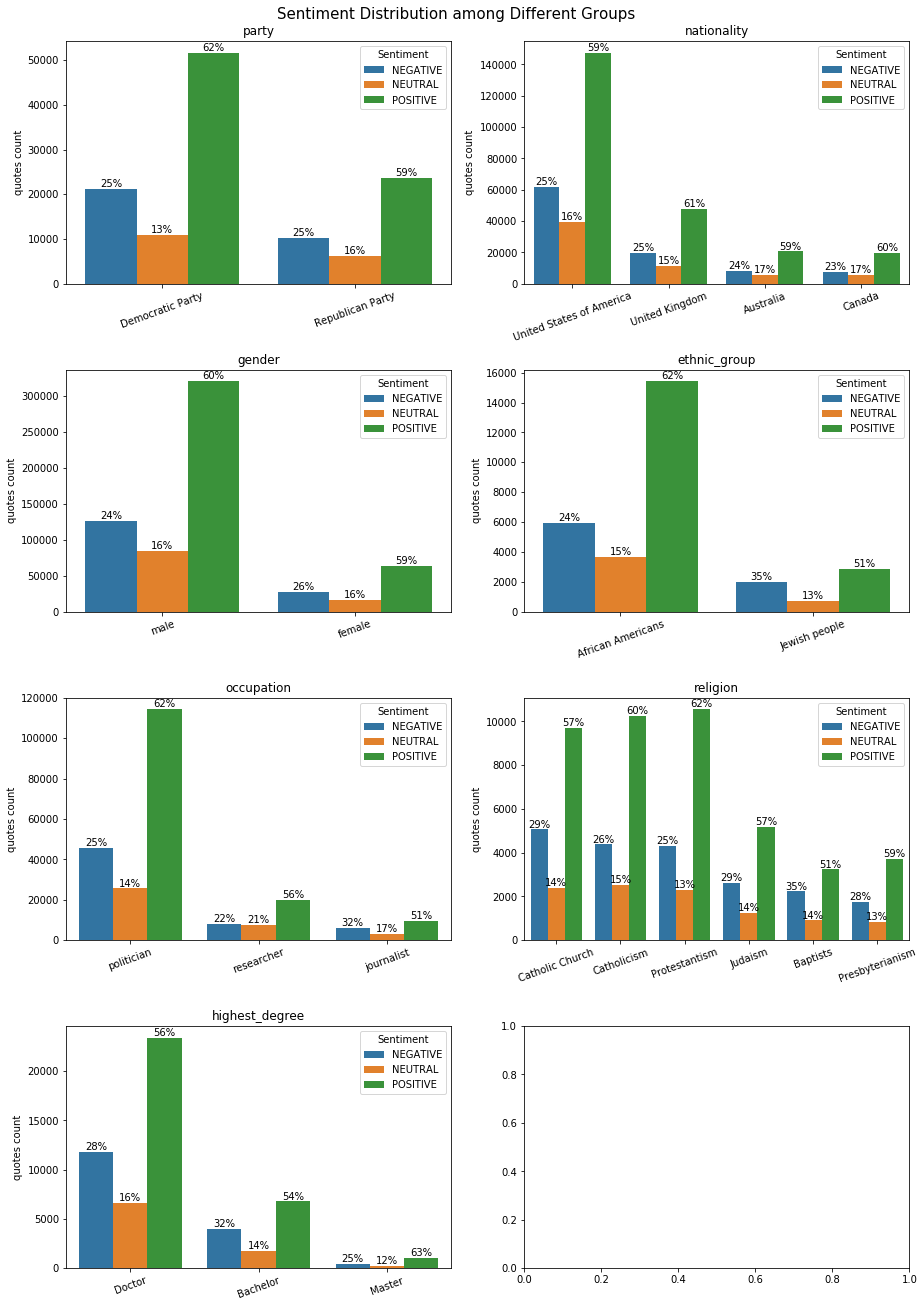

In [94]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 18))
for idx, key in enumerate(target_dict):
    ax = axes[int(idx/2), idx%2]
    filtered_data = data[data[key].isin(target_dict[key])]
    sns.countplot(x=key, hue='Sentiment', data=filtered_data, ax=ax, \
                  order=filtered_data[key].value_counts().index, hue_order=['NEGATIVE','NEUTRAL','POSITIVE'])
    ax.set_xlabel("")
    ax.set_ylabel('quotes count')
    ax.tick_params('x', labelrotation=20)
    ax.set_title(key)
    add_percent(len(target_dict[key]),ax)
fig.text(0.3,1, 'Sentiment Distribution among Different Groups', va='center',fontsize=15)
# plt.suptitle('Sentiment Distribution among Different Groups',size=12)
fig.tight_layout()

*Discuss*: There's no significant attitudes difference towards climate change between different parties, countries or genders. However, we can tell from the figure that **Jewish people** (who also mostly believe in Judaism) tend to react negatively towards climate change issue. Also, the negative attitude seems to be more prevalent among **journalists** and people who are **less educated** (with bachelor degree).

Then we discuss *age* attribute. It covers a large range because some quotations are from the saying of historical figures, and some are due to wrong duplicate names. Therefore, we only analyze the quotations of people nowadays. Suppose that people are between the age of 20 and 90 when they made the quotation.

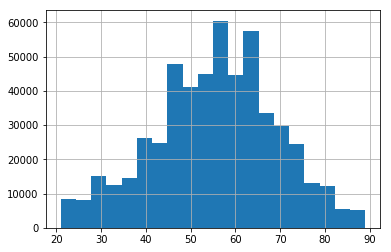

In [310]:
filtered_data = data[(data['age']<90) & (data['age']>20)]
filtered_data['age'].hist(bins=20)

Text(0.5, 1.0, 'Sentiment Distribution among Different Age Groups')

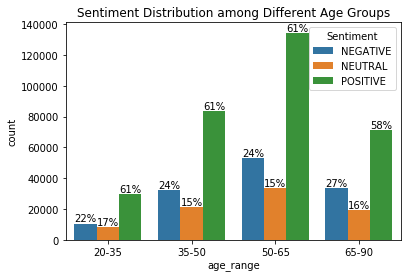

In [312]:
# discuss on age atrribute
# group age by range
filtered_data['age_range'] = pd.cut(filtered_data['age'],[20, 35, 50, 65, 90],labels=['20-35','35-50','50-65','65-90'])
ax = sns.countplot(x='age_range', hue='Sentiment', data=filtered_data, \
              order=['20-35','35-50','50-65','65-90'], hue_order=['NEGATIVE','NEUTRAL','POSITIVE'])
add_percent(4,ax)
plt.title('Sentiment Distribution among Different Age Groups')

It seems that the older the people get, the more inclined they are to climate denialism.

### We are not content with the superficial analysis such as the above because we are aware of the dangers of observational studies--the presence of **confounders**, so in the following analysis we try to balance the groups via matching and get a more solid causality relationship.

We use the method: **Inverse Propensity Score Weight (IPSW)**. IPTW is similar to propensity score model (PSM) and it provides an estimation of the **Average Treatment Effect (ATE)** to quantify the difference between the treatment and control groups.

### 1. the causal effect of the occupation

The **covariates pool** includes *party,nationality,gender, ethnic group, occupation, religion, age* and *highest degree*. Due to the large amount of missing values, we exclude *party (63.7% missing)*, *ethnic group (91.2% missing)*, *religion (80.3% missing)*, *highest egree (91.4% missing)*. Therefore, the **chosen covariates** are: *nationality, gender* and *age*

In [ ]:
demographic_data = data[data['Seniment'] == 'NEGATIVE']

In [248]:
demographic_data_dropna = demographic_data.dropna(subset=['occupation','gender','nationality','age'],how='any').copy()

In [249]:
demographic_data_new = demographic_data_dropna[['occupation','gender','nationality','age','avg_score']].copy()

In [250]:
demographic_data_dummy = pd.get_dummies(demographic_data_new)

In [251]:
demographic_data_dummy.shape

(29687, 1266)

In [184]:
variable_pool = demographic_data_dummy.columns.tolist()
variable_pool.remove('avg_score')
covariate = [x for x in variable_pool if not x.startswith('occupation')]

we analyse only the top 5 occupations to avoid the **imbalance** between the control and treatment groups

In [185]:
top_5_occupations = demographic_data_dropna.occupation.value_counts().index[:5].tolist()

In [222]:
from causalinference import *
ipse_occupation_list=[]
for x in top_5_occupations:
    print(x)
    cm = CausalModel(
        Y=demographic_data_dummy.avg_score.values, 
        D=demographic_data_dummy['occupation_'+x].values, 
        X=demographic_data_dummy[covariate].values)
    cm.est_propensity()
    propensity = cm.propensity["fitted"]
    df = demographic_data_dummy
    df["ips"] = np.where(
        df['occupation_'+x] == 1, 
        1 / propensity,
        1 / (1 - propensity))
    df["ipsw"] = df.avg_score * df.ips
    ipse = (
      df[df['occupation_'+x] == 1]["ipsw"].sum()
    - df[df['occupation_'+x] == 0]["ipsw"].sum()
) / df.shape[0]
    ipse_occupation_list.append(ipse)
    print(ipse)

politician
0.11335974882101876
association football player
-0.015098378619321716
actor
0.009717960609134876
journalist
-0.026214259390041465
writer
-0.038717305534524696


*Discuss*: From the result, the score difference between the politician and non-politician is largest, which reaches 0.113. This means being a politician tends to have more positive attitude towards the climate change issues, while being a writer has a more negative effect.

### 2. the causal effect of the nationality

Apply the same method, we analyse the causal effect of the first 10 nationalities.

In [191]:
top_10_nationality = demographic_data_dropna.nationality.value_counts().index[:10].tolist()

In [192]:
top_10_nationality

['United States of America',
 'United Kingdom',
 'Australia',
 'Canada',
 'Germany',
 'India',
 'New Zealand',
 'France',
 'Ireland',
 'South Africa']

In [228]:
ipse_nationality_list = []
for x in top_10_nationality:
    
    print(x)
    cm = CausalModel(
        Y=demographic_data_dummy.avg_score.values, 
        D=demographic_data_dummy['nationality_'+x].values, 
        X=demographic_data_dummy[covariate].values)
    cm.est_propensity()
    propensity = cm.propensity["fitted"]
    df = demographic_data_dummy
    df["ips"] = np.where(
        df['nationality_'+x] == 1, 
        1 / propensity,
        1 / (1 - propensity))
    df["ipsw"] = df.avg_score * df.ips
    ipse = (
      df[df['nationality_'+x] == 1]["ipsw"].sum()
    - df[df['nationality_'+x] == 0]["ipsw"].sum()
) / df.shape[0]
    ipse_nationality_list.append(ipse)
    print(ipse)

United States of America
0.0002088484855778383
United Kingdom
0.004248348467226155
Australia
0.012644026694551095
Canada
0.02378461711012297
Germany
0.026921731083691464
India
-0.0176584561758974
New Zealand
0.023423053525463807
France
-0.03712422704923801
Ireland
-0.00560190750329531
South Africa
-0.013051471928679587


In [229]:
ipse_nationality_list

[0.0002088484855778383,
 0.004248348467226155,
 0.012644026694551095,
 0.02378461711012297,
 0.026921731083691464,
 -0.0176584561758974,
 0.023423053525463807,
 -0.03712422704923801,
 -0.00560190750329531,
 -0.013051471928679587]

From the result, people from France tend to have more negative attitude, while being German will improve the sentiment score most. 

### 3. The casual effect of the age

We define the people from 18-60 as adults, above 60 as elderly.

In [239]:
def judge_age(x):
    if x<=18:
        return 'teen'
    if x>18 and x<=60:
        return 'adult'
    if x>60:
        return 'elderly'
demographic_data_new.age = demographic_data_new.age.apply(judge_age)

In [240]:
demographic_data_new.age.value_counts()

adult      18655
elderly    10438
teen         594
Name: age, dtype: int64

In [241]:
demographic_data_dummy = pd.get_dummies(demographic_data_new)

In [242]:
ipse_age_list = []
for x in ['adult','elderly']:
    print(x)
    
    cm = CausalModel(
        Y=demographic_data_dummy.avg_score.values, 
        D=demographic_data_dummy['age_'+x].values, 
        X=demographic_data_dummy[covariate].values)
    cm.est_propensity()
    propensity = cm.propensity["fitted"]
    df = demographic_data_dummy
    df["ips"] = np.where(
        df['age_'+x] == 1, 
        1 / propensity,
        1 / (1 - propensity))
    df["ipsw"] = df.avg_score * df.ips
    ipse = (
      df[df['age_'+x] == 1]["ipsw"].sum()
    - df[df['age_'+x] == 0]["ipsw"].sum()
) / df.shape[0]
    ipse_age_list.append(ipse)
    print(ipse)

adult
0.008763764149412705
elderly
-0.009645790890902275


Being an elderly may cause the decrease in the sentiment score, elder people are more inclined to climate denialism

### 4. The casual effect of gender

In [206]:
gender = demographic_data_dropna.gender.value_counts().index[:5].tolist()

In [207]:
gender

['male', 'female', 'transgender female', 'non-binary', 'genderfluid']

In [252]:
ipse_gender_list = []
for x in gender:
    print(x)
    
    cm = CausalModel(
        Y=demographic_data_dummy.avg_score.values, 
        D=demographic_data_dummy['gender_'+x].values, 
        X=demographic_data_dummy[covariate].values)
    cm.est_propensity()
    propensity = cm.propensity["fitted"]
    df = demographic_data_dummy
    df["ips"] = np.where(
        df['gender_'+x] == 1, 
        1 / propensity,
        1 / (1 - propensity))
    df["ipsw"] = df.avg_score * df.ips
    ipse = (
      df[df['gender_'+x] == 1]["ipsw"].sum()
    - df[df['gender_'+x] == 0]["ipsw"].sum()
) / df.shape[0]
    ipse_gender_list.append(ipse)
    print(ipse)

male
47.430420928681045
female
-21.606692810556943
transgender female
0.06320433284380815
non-binary
-0.19868491446024814
genderfluid
0.34027406400785354


We can see that female may greatly cause the decrease in the sentiment score, which means that women speakers appear to be more negative to this issue. 

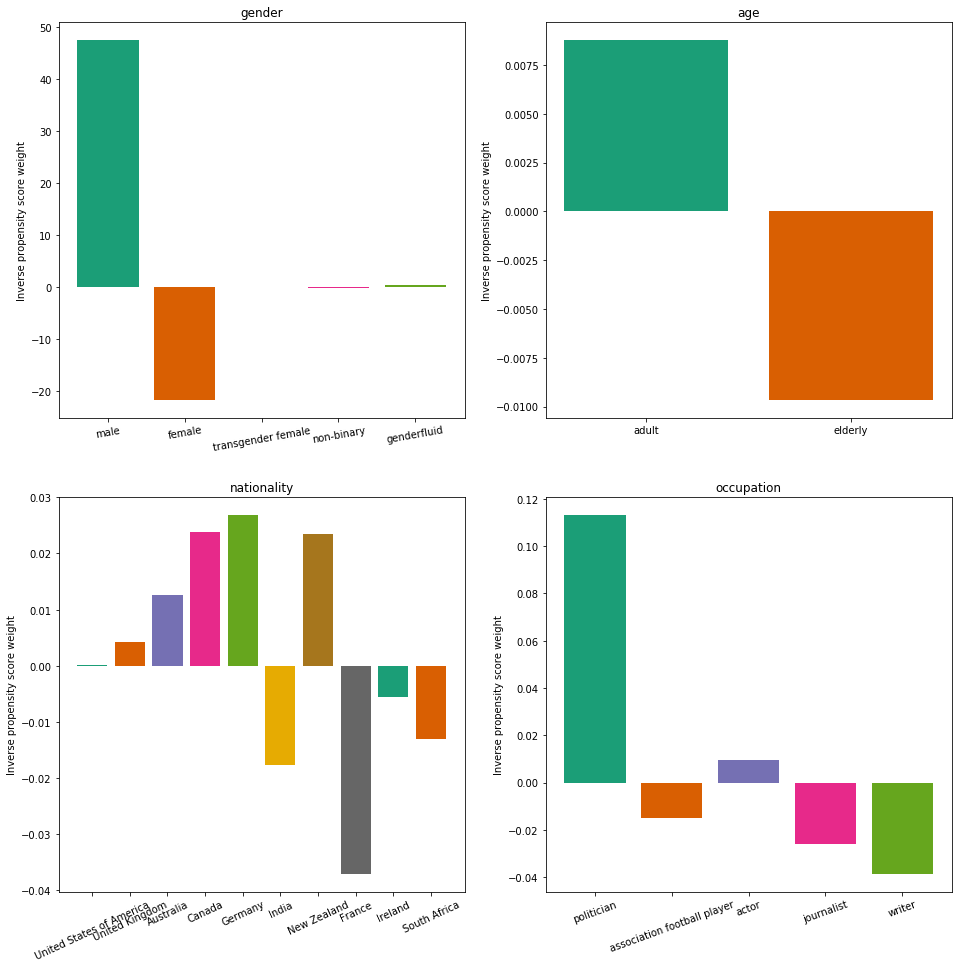

In [278]:
# draw a graph:
import brewer2mpl
bmap = brewer2mpl.get_map('Dark2', 'qualitative', 8)
colors = bmap.mpl_colors
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.bar(gender,ipse_gender_list,color=colors)
plt.xticks(rotation=10)
plt.ylabel('Inverse propensity score weight')
plt.title('gender')
plt.subplot(2,2,2)
plt.bar(['adult','elderly'],ipse_age_list,color=colors)
plt.ylabel('Inverse propensity score weight')
plt.title('age')
plt.subplot(2,2,3)
plt.bar(top_10_nationality,ipse_nationality_list,color=colors)
plt.xticks(rotation=25)
plt.ylabel('Inverse propensity score weight')
plt.title('nationality')
plt.subplot(2,2,4)
plt.bar(top_5_occupations,ipse_occupation_list,color=colors)
plt.ylabel('Inverse propensity score weight')
plt.title('occupation')
plt.xticks(rotation=20)
plt.show()

## Limitations:
There are certain limitations of our study
1. Due to the concern of ruling out too many data, we keep all the quotations that are related to climate change, of which about 50% are from an american speaker. In other words, speakers from the U.K. (15%), Australia (6%) and Canada (6%) are also included, which might have resulted in bias when calculating political attention rate and political support rate.
2. When performing sentiment analysis, we completely depend on the popular Vader toolkit. Since this tool is specifically attuned to sentiments expressed in social media, it might result in some bias when applied to our dataset. Moreover, the judgment of "negative" and "positive" attitudes towards climate change is even more tricky, for example, given two similar sentences: "Climate change is really bad" and "This policy regarding climate change is really bad", although they are all labeled as negative by Vader, the first sentence can mean that we should take actions to mitigate climate change, which, under our definition, should be labeled as positive. Last but not least, as we mentioned before, under the topic of climate change, few of the quotations should be "neutral" or only describe some facts. Either they implies a concern/support that human should take actions to mitigate climate change, or they are not in favor of it. Therefore, in theory, the appropriate threshold of "neutral" is very hard to define, at least it should be a narrower range than (-0.05,0.05).
3. In the given dataset, there's a possibility of duplicate names when linking the speaker with their qids. To find out which one is the real speaker, we build upa filter based on their born year (suppose that the speaker should age between 20 and 90). This might not be effective enough and can result in some faults, for example, we found out that the youngest speaker in our dataset is -5, which is clearly due to a wrong linked figure who has the same name. However, cases of duplicate names are not dominant, which will not significantly affect our results.
4. In Task 2, the superficial conclusion of higher negative rate among certain people (Jewish, journalists, less educated, elder) can be caused by unbalanced distribution of data. Moreover, this doesn't mean that these people are more indifferent to climate change, since there can be many confounders.
5. In the IPTW-matching analysis, we filter out some groups due to their small number, since the number treated/untreated data samples should be larger than the number of covariates. By doing this, we probably filter out some "minorities" which might triger interesting findings.